# Attempting a minimal diffusion model

In [1]:
import logging, torch, torchvision, torch.nn.functional as F, torchvision.transforms.functional as TF, matplotlib as mpl
from matplotlib import pyplot as plt
from functools import partial
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torchvision.utils import make_grid
from datasets import load_dataset,load_dataset_builder
from miniai.datasets import *
from miniai.learner import *
from fastprogress import progress_bar
from timm.optim.rmsprop_tf import RMSpropTF
from timm.optim.adafactor import Adafactor
from timm.optim.lookahead import Lookahead
from fastai.callback.schedule import combined_cos
from fastai.layers import SequentialEx, MergeLayer
from fastai.losses import MSELossFlat
# Perceptual loss
import lpips

In [2]:
def RmsLookahead(params, alpha=0.5, k=6, *args, **kwargs):
    opt = RMSpropTF(params, *args, **kwargs)
    return Lookahead(opt, alpha, k)

In [3]:
def AdamLookahead(params, alpha=0.5, k=6, *args, **kwargs):
    opt = optim.Adam(params, *args, **kwargs)
    return Lookahead(opt, alpha, k)

In [4]:
mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

Load a dataset:

In [5]:
x,y = 'image','label'
#name = "mnist" #"fashion_mnist"
name = "fashion_mnist"
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

In [7]:
device = 'cuda'
loss_fn_alex = lpips.LPIPS(net='alex').to(device)
loss_fn_mse = MSELossFlat()
pl_resizer = torchvision.transforms.Resize(64)

def combined_loss(preds, y):
    resized_preds = pl_resizer(preds)
    resized_y = pl_resizer(y)
    return loss_fn_alex.forward(resized_preds, resized_y).mean() + loss_fn_mse(preds, y)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


C:\Users\jsa16\anaconda3\envs\course22p2\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\jsa16\anaconda3\envs\course22p2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: C:\Users\jsa16\anaconda3\envs\course22p2\lib\site-packages\lpips\weights\v0.1\alex.pth


In [8]:
opt_func = optim.Adam
loss_func = combined_loss
lr_max = 1e-3
bs = 256
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([256, 1, 28, 28]), tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5]))

Define a model:

In [9]:
def conv2dks7(inc, outc, stride=1): return nn.Conv2d(inc, outc, kernel_size=7, padding=3, stride=stride)
def conv2dks5(inc, outc, stride=1): return nn.Conv2d(inc, outc, kernel_size=7, padding=2, stride=stride)
def conv2dks3(inc, outc, stride=1): return nn.Conv2d(inc, outc, kernel_size=3, padding=1, stride=stride)
def conv2dks1(inc, outc): return nn.Conv2d(inc, outc, kernel_size=1)
def conv2dtrans(inc, outc): return nn.ConvTranspose2d(inc, outc, 4, 2, 1)

def residual_layer(inc, norm):
    return SequentialEx(conv2dks3(inc, inc), act(), norm(num_channels=inc),
                        conv2dks3(inc, inc), act(), norm(num_channels=inc),
                        MergeLayer(False))

In [10]:
norm = partial(torch.nn.GroupNorm, num_groups=8)
#norm = torch.nn.BatchNorm2d
act = torch.nn.SiLU

def init_layer(inc, outc):
    return torch.nn.Sequential(conv2dks7(inc, outc), act(), norm(num_channels=outc),
                               conv2dks3(outc, outc, 2), act(), norm(num_channels=outc),
                               residual_layer(outc, norm))

def down_layer(inc, outc):
    return torch.nn.Sequential(conv2dks3(inc, outc, 2), act(), norm(num_channels=outc),
                               residual_layer(outc, norm))

def up_layer(inc, outc):
    layers = [conv2dks1(inc, inc//2), act(), norm(num_channels=inc//2), 
              residual_layer(inc//2, norm),
              conv2dtrans(inc//2, outc), act(), norm(num_channels=outc)]
    return torch.nn.Sequential(*layers)

def out_layer(inc, midc, outc):
    layers = [conv2dks1(inc, midc), act(), norm(num_channels=midc), 
          residual_layer(midc, norm),
          conv2dks3(midc, outc)]
    return torch.nn.Sequential(*layers)

In [11]:
class BasicUNet(nn.Module):
    "A minimal UNet implementation."
    def __init__(self, inc, outc):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([init_layer(inc,32), down_layer(32, 64), down_layer(64, 64)])
        self.up_layers = torch.nn.ModuleList([up_layer(128, 64), up_layer(128,32), up_layer(64, 32)])
        self.out_layers = out_layer(inc+32, 32, outc)

    def forward(self, x):
        x_orig = x.clone()
        h = []
        for i, l in enumerate(self.down_layers):
            x = l(x)
            h.append(x)
            #if i < 2: x = F.max_pool2d(x, 2)
        for i, l in enumerate(self.up_layers):
            x_cross = h.pop()
            if x.shape[-2:] != x_cross.shape[-2:]:
                x = F.interpolate(x, x_cross.shape[-2:], mode='nearest')
            x = torch.cat([x_cross,x], dim=1)
            x = l(x)
                                             
        if x.shape[-2:] != x_orig.shape[-2:]:
            x = F.interpolate(x, x_orig.shape[-2:], mode='nearest')                                       
        x = torch.cat([x_orig,x], dim=1)
        x = self.out_layers(x)                                    
        x = x.sigmoid()
        return x

Define the corruption:

In [12]:
def corrupt(x, amount):
    "Corrupt the input `x` by mixing it with noise according to `amount`"
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
    return x*(1-amount) + noise*amount

Logging callback:

In [13]:
class LogLossesCB(Callback):
    def __init__(self): self.losses = []
    def after_batch(self): self.losses.append(self.learn.loss.item())
    def after_fit(self): plt.plot(self.losses)

I chose to write a new training callback:

In [14]:
class OneCycle(Callback):
    def __init__(self, lr_max): 
        lr_max = lr_max
        div=25.
        div_final=1e5
        pct_start=0.3
        self.lr_sched_fn = combined_cos(pct_start, lr_max/div, lr_max, lr_max/div_final)
        self.ns = []
    def after_batch(self): 
        self.ns.append(bs)
        n_steps = len(self.learn.dls.train) * self.learn.n_epochs * bs
        i = sum(self.ns)
        pos = i/(n_steps)
        lr = self.lr_sched_fn(pos)
        self.learn.lr = lr
        
    def before_fit(self): 
        lr = self.lr_sched_fn(0)
        self.learn.lr = lr

In [15]:
class MyTrainCB(TrainCB):
    def predict(self):
        bs = self.learn.batch[0].shape[0]
        noise_amount = torch.rand(bs).to(self.learn.batch[0].device) # Chose random corruption amount
        noisy_images = corrupt(self.learn.batch[0], noise_amount) # Noisy images as net inputs
        self.learn.preds = self.learn.model(noisy_images)
    def get_loss(self):
        self.learn.loss = self.learn.loss_func(self.learn.preds, self.learn.batch[0]) # Clean images as targets

In [16]:
model = BasicUNet(1, 1)
cbs = [MyTrainCB(), CudaCB(), ProgressCB(), LogLossesCB(), OneCycle(lr_max)]
learn = Learner(model, dls, loss_func, lr=lr_max, cbs=cbs, opt_func=opt_func)

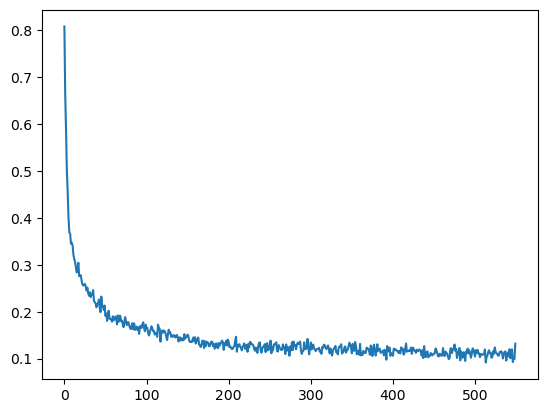

In [17]:
learn.fit(2) 

Viewing the predictions on images with increasing noise levels:

In [18]:
# Some noisy data
xb = xb[:8].cpu()
amount = torch.linspace(0, 1, xb.shape[0]) # Left to right -> more corruption
noised_x = corrupt(xb, amount)

In [19]:
with torch.no_grad(): preds = model(noised_x.cuda()).detach().cpu()

In [20]:
def show_grid(ax, tens, title=None):
    if title: ax.set_title(title)
    ax.imshow(make_grid(tens.cpu())[0])

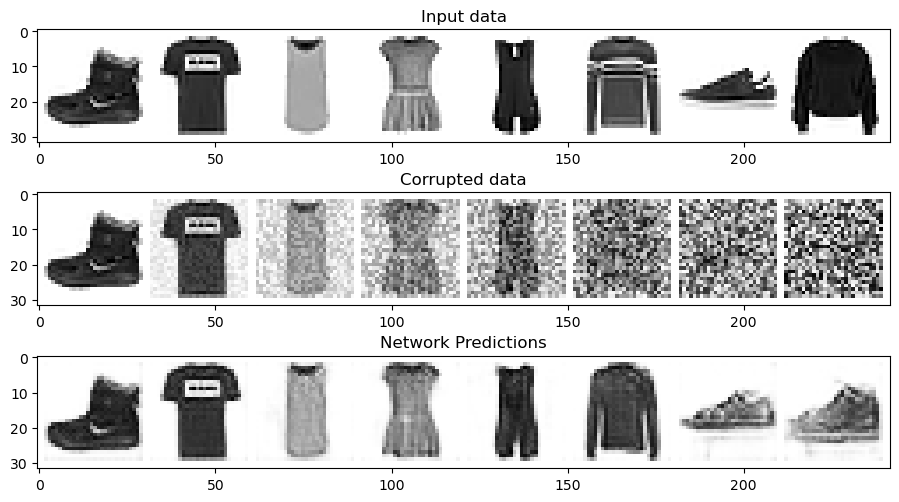

In [21]:
fig, axs = plt.subplots(3, 1, figsize=(11, 6))
show_grid(axs[0], xb, 'Input data')
show_grid(axs[1], noised_x, 'Corrupted data')
show_grid(axs[2], preds, 'Network Predictions')

(array([379.,  28.,  11.,   9.,  11.,  12.,  15.,  51., 163., 105.]),
 array([9.8057790e-06, 9.2459232e-02, 1.8490866e-01, 2.7735808e-01,
        3.6980751e-01, 4.6225697e-01, 5.5470639e-01, 6.4715582e-01,
        7.3960525e-01, 8.3205467e-01, 9.2450410e-01], dtype=float32),
 <BarContainer object of 10 artists>)

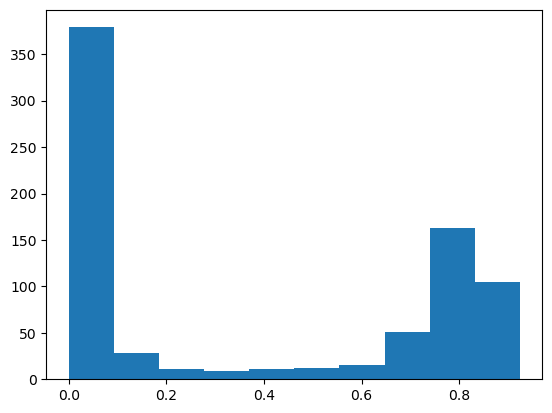

In [22]:
plt.hist(preds[0].reshape(-1))

A very basic sampling method (not ideal), just taking 5 or 10 equal-sized steps towards the models prediction:

In [23]:
# Take one: just break the process into 5 or 10 steps and move 1/10'th of the way there each time:
n_steps = 5
xb = torch.rand(8, 1, 28, 28).to(device) # Start from random
step_history = [xb.detach().cpu()]
pred_output_history = []

In [24]:
for i in range(n_steps):
    with torch.no_grad(): pred = model(xb) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store model output for plotting
    mix_factor = 1/(n_steps - i) # How much we move towards the prediction
    xb = xb*(1-mix_factor) + pred*mix_factor # Move part of the way there
    if i < n_steps-1: step_history.append(xb.detach().cpu()) # Store step for plotting

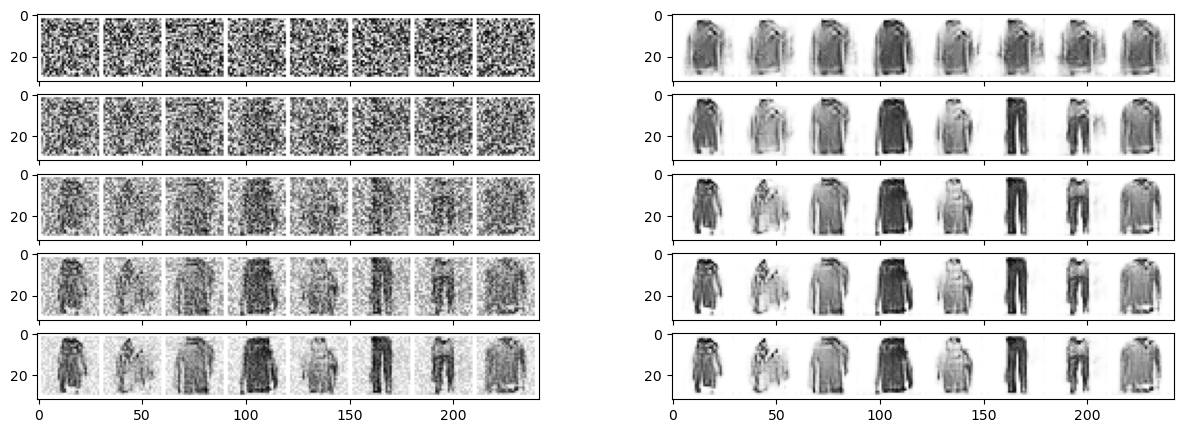

In [25]:
fig, axs = plt.subplots(n_steps, 2, figsize=(15, n_steps), sharex=True)
for i in range(n_steps):
    axs[i, 0].imshow(make_grid(step_history[i])[0]),
    axs[i, 1].imshow(make_grid(pred_output_history[i])[0])

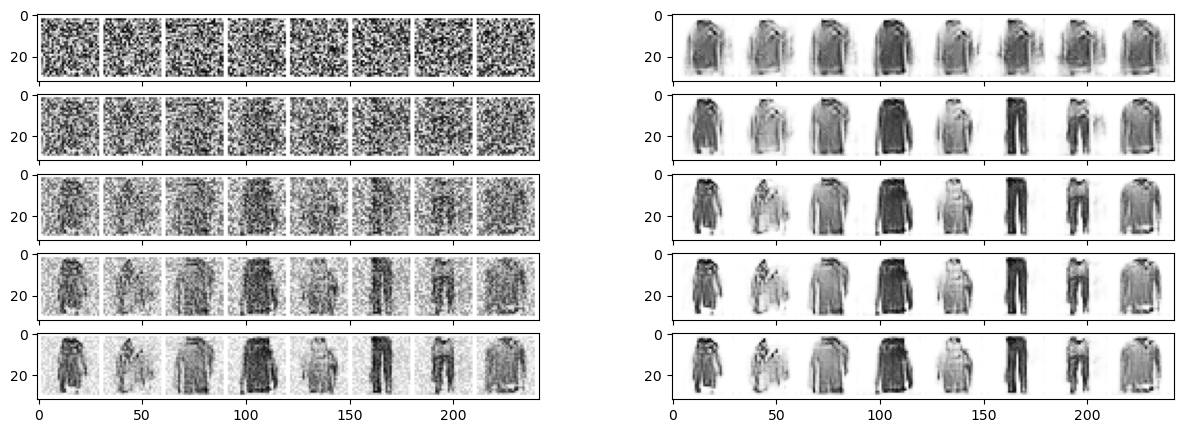

In [26]:
fig, axs = plt.subplots(n_steps, 2, figsize=(15, n_steps), sharex=True)
for i in range(n_steps):
    axs[i, 0].imshow(make_grid(step_history[i])[0]),
    axs[i, 1].imshow(make_grid(pred_output_history[i])[0])

# Class Conditioning

Giving the model the labels as conditioning.

In [27]:
class ClassConditionedUNet(nn.Module):
    "Wraps a BasicUNet but adds several input channels for class conditioning"
    def __init__(self, in_channels, out_channels, num_classes=10, class_emb_channels=4):
        super().__init__()
        self.class_emb = nn.Embedding(num_classes, class_emb_channels)
        self.net = BasicUNet(in_channels+class_emb_channels, out_channels) # input channels = in_channels+1+class_emb_channels

    def forward(self, x, class_labels):
        n,c,w,h = x.shape
        class_cond = self.class_emb(class_labels) # Map to embedding dinemsion
        class_cond = class_cond.view(n, class_cond.shape[1], 1, 1).expand(n, class_cond.shape[1], w, h) # Reshape
        
        # Net input is now x, noise amound and class cond concatenated together
        net_input = torch.cat((x, class_cond), 1)
        return self.net(net_input)

In [28]:
class MyTrainCB(TrainCB):
    def predict(self):
        bs = self.learn.batch[0].shape[0]
        noise_amount = torch.rand(bs).to(self.learn.batch[0].device)
        noisy_images = corrupt(self.learn.batch[0], noise_amount)
        self.learn.preds = self.learn.model(noisy_images, self.learn.batch[1]) # << Labels as conditioning
    def get_loss(self): self.learn.loss = self.learn.loss_func(self.learn.preds, self.learn.batch[0])

In [29]:
model = ClassConditionedUNet(1, 1)
cbs = [MyTrainCB(), CudaCB(), ProgressCB(), LogLossesCB(), OneCycle(lr_max)]
learn = Learner(model, dls, loss_func, lr=1e-3, cbs=cbs, opt_func=opt_func)

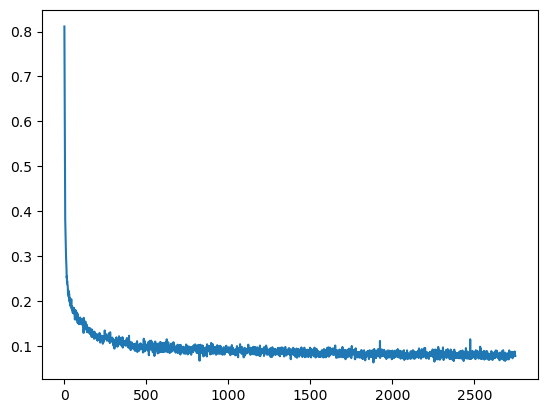

In [30]:
learn.fit(10)

Sampling as before over 20 steps, but this time with the labels as conditioning:

In [31]:
n_steps = 20
xb = torch.rand(80, 1, 28, 28).cuda()
yb = torch.tensor([[i]*8 for i in range(10)]).flatten().cuda()

In [32]:
for i in range(n_steps):
    noise_amount = torch.ones((xb.shape[0], )).to(device) * (1-(i/n_steps))
    with torch.no_grad():
        pred = model(xb, yb)
    mix_factor = 1/(n_steps - i)
    xb = xb*(1-mix_factor) + pred*mix_factor
    
    # Optional: Add a bit of extra noise back at early steps
    if i < 10: xb = corrupt(xb, torch.ones((xb.shape[0], )).to(device)*0.05)

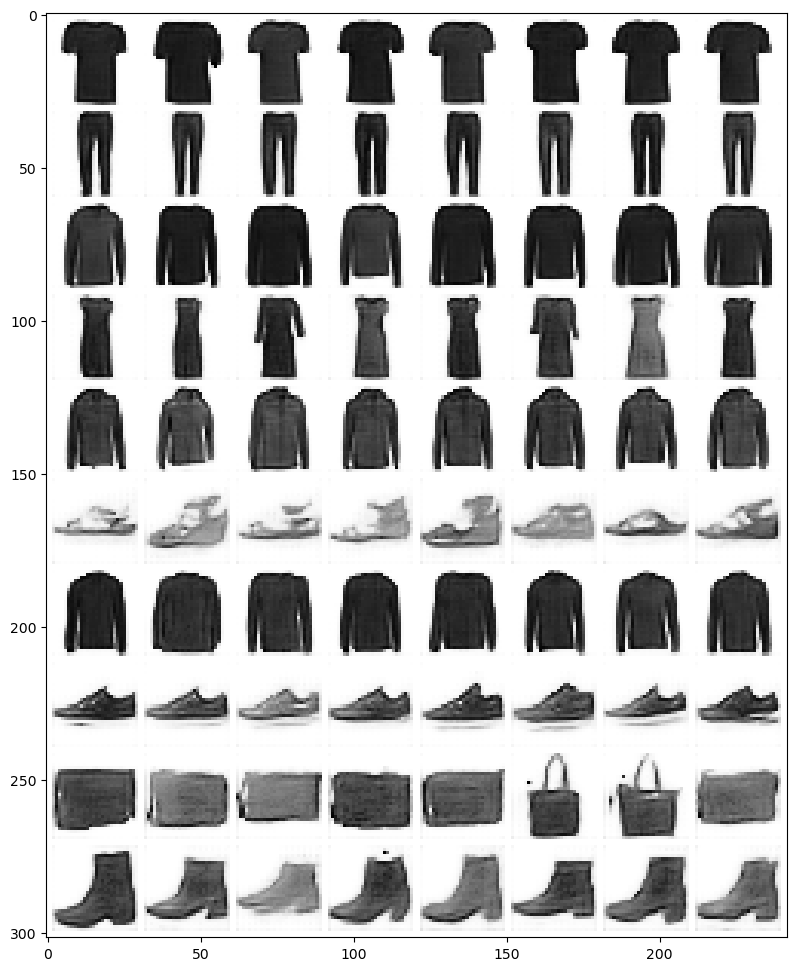

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(make_grid(xb.detach().cpu().clip(0, 1), nrow=8)[0]);

You can try fashion_mnist as the dataset without making any changes. This seems to work (suprisingly given the lack of fiddling with training and architecture). 